![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Advanced Methods in Natural Language Processing - Session 4

# Text Classification with AG News Corpus

This notebook will guide you through different approaches to text classification using the AG News corpus. We will start with a simple baseline model and gradually move towards more complex and sophisticated models.

## Table of Contents

1. **[Part 1: Baseline Pipeline with TF-IDF and Linear Model](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Feature Extraction with TF-IDF
   - 1.3. Training a Linear Model
   - 1.4. Model Evaluation

2. **[Part 2: LSTM Pipeline with One-Hot Encoding](#part2)**
   - 2.1. Preprocessing for LSTM
   - 2.2. Building a Bidirectional LSTM Model
   - 2.3. Training the LSTM Model
   - 2.4. Model Evaluation

3. **[Part 3: Word Embedding Add-Ons with Word2Vec](#part3)**
   - 3.1. Loading Pre-trained Word2Vec Embeddings
   - 3.2. Integrating Word2Vec into LSTM Model
   - 3.3. Training and Evaluating the Model

4. **[Part 4: Model Explainability (LIME / SHAP)](#part4)**
   - 4.1. Why Explainability Matters  
   - 4.2. Applying LIME to the TF-IDF Model  
   - 4.3. Comparing Explanation for LSTM with Word2Vec model

## Part 0: Metrics Functions to Consider

Before diving into the model building and training, it's crucial to establish the metrics we'll use to evaluate our models. In this part, we will define and discuss the different metrics functions that are commonly used in NLP tasks, particularly for text classification:

1. **Accuracy**: Measures the proportion of correct predictions among the total number of cases examined. It's a straightforward metric but can be misleading if the classes are imbalanced.

2. **Precision and Recall**: Precision measures the proportion of positive identifications that were actually correct, while recall measures the proportion of actual positives that were identified correctly. These metrics are especially important when dealing with imbalanced datasets.

3. **F1 Score**: The harmonic mean of precision and recall. It's a good way to show that a classifer has a good balance between precision and recall.

4. **Confusion Matrix**: A table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

5. **ROC and AUC**: The receiver operating characteristic curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system. The area under the curve (AUC) represents measure of separability.

We will implement these metrics functions using libraries such as scikit-learn, and they will be used to assess and compare the performance of our different models throughout this exercise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

## Part 1: Baseline Pipeline with TF-IDF and Linear Model

In this part, we will create a baseline model for text classification. This involves:

### 1. **Loading and Exploring Data**:

We will load the AG News corpus and perform necessary preprocessing steps like exploring the dataset.

In [2]:
from datasets import load_dataset

# Load the 'ag_news' dataset
dataset = load_dataset("ag_news")

# Explore the structure of the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


Let's create stratified samples for training and validation sets ensuring that each class is represented in proportion to its frequency. It will go faster with just a sample, and we will be able to make tests on validation test before trying to work on the testing set.

In [3]:
from sklearn.model_selection import train_test_split

data = dataset['train']['text']
labels = dataset['train']['label']

test_data = dataset['test']['text']
test_labels = dataset['test']['label']

# Stratified split to create a smaller training and validation set
train_data, valid_data, train_labels, valid_labels = train_test_split(
    data, labels, stratify=labels, test_size=0.2, random_state=42
)

# Further split to get 10k and 2k samples respectively
train_data, _, train_labels, _ = train_test_split(
    train_data, train_labels, stratify=train_labels, train_size=10000, random_state=42
)
valid_data, _, valid_labels, _ = train_test_split(
    valid_data, valid_labels, stratify=valid_labels, train_size=2000, random_state=42
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/agomberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


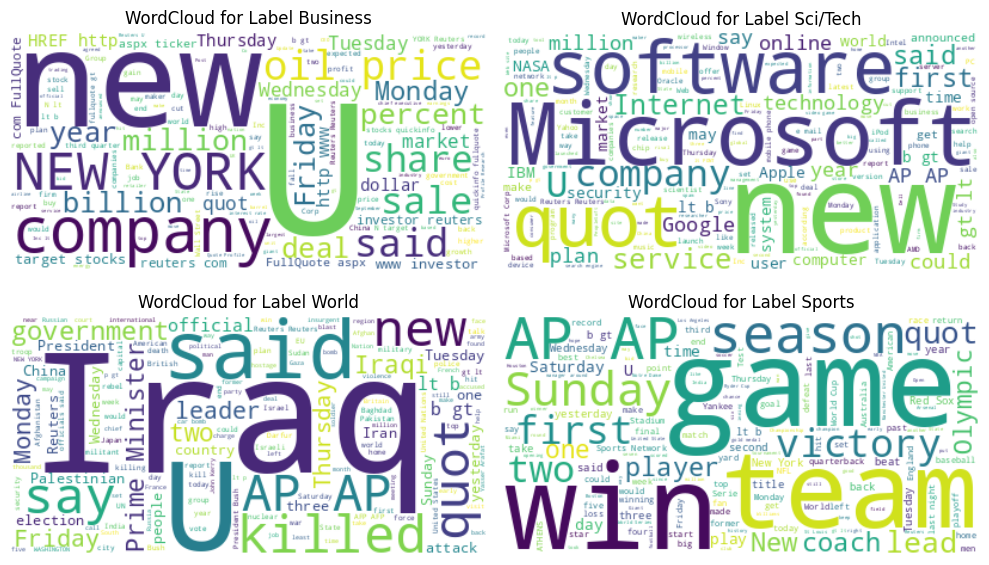

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'World', 1: 'Sports',
          2: 'Business', 3: 'Sci/Tech'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(train_data, train_labels):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(2, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

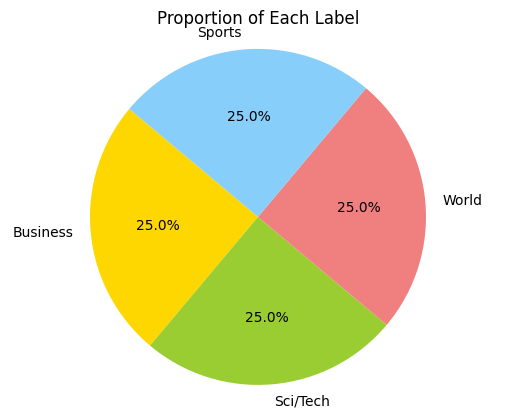

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the frequency of each label
label_counts = Counter(train_labels)

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Each Label')
plt.show()


### 2. **Feature Extraction with TF-IDF**:

We will convert the text data into numerical form using the TF-IDF vectorization technique. We will use the `Pipeline` class from scikit-learn which is really practical.

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline.fit(train_data, train_labels)

valid_preds = pipeline.predict(valid_data)

NameError: name 'train_data' is not defined

In [7]:
metrics_val= Metrics()
metrics_val.run(valid_labels, valid_preds, "basic TF-IDF")

### 3. **Training with Cross Validation**:

We will train a linear classifier (such as Logistic Regression) using the extracted features, `Pipeline` module and cross validation with `GridSearchCV`.

In [8]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__min_df': [1, 2, 5],  # Example values, you can choose others
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)]  # Unigrams, bigrams or both
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(train_data, train_labels)

# Best parameters found by grid search
print(f'Best Parameters: {grid_search.best_params_}')

# Evaluate on the validation set
valid_preds = grid_search.predict(valid_data)
metrics_val.run(valid_labels, valid_preds, "CV-ed TF-IDF")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}


### 4. **Model Evaluation**:

We will evaluate the performance of our model on a separate test set using various metrics.

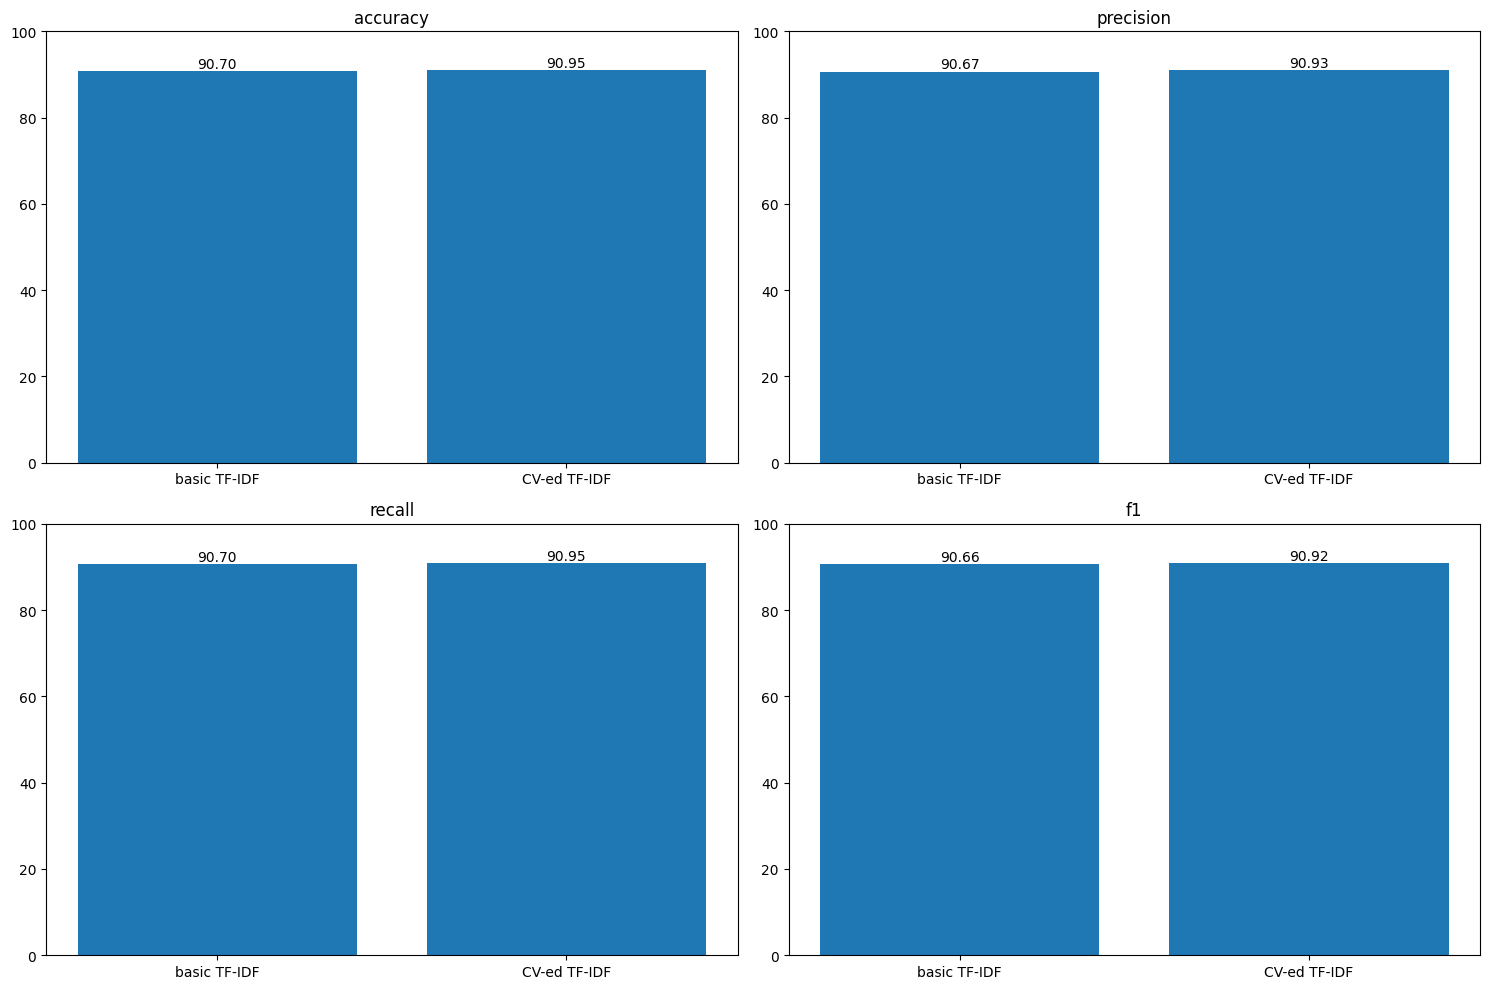

In [9]:
metrics_val.plot()

## Part 2: LSTM Pipeline with One-Hot Encoding

In this part, we'll explore a more complex model using LSTM:

### 1. **Preprocessing for LSTM**:

We'll prepare the text data for LSTM, which involves tokenization and converting words to one-hot encoded vectors.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
vocab_size = 5000  # This is a hyperparameter, adjust as needed
max_length = 128    # This is another hyperparameter

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data)

# Convert texts to sequences of integers
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_valid = tokenizer.texts_to_sequences(valid_data)

# Pad sequences to the same length
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_length,
                                 padding='post', truncating='post')
padded_sequences_valid = pad_sequences(sequences_valid, maxlen=max_length,
                                 padding='post', truncating='post')


# Assuming train_labels are integer labels
num_classes = len(set(train_labels))  # Determine the number of unique classes

# Convert labels to one-hot vectors
train_labels_lstm = to_categorical(train_labels, num_classes=num_classes)
valid_labels_lstm = to_categorical(valid_labels, num_classes=num_classes)

### 2. **Building a Bidirectional LSTM Model**:

We'll design a neural network with a Bidirectional LSTM layer to capture context from both directions in the text.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.metrics import Precision, Recall

model = Sequential([
    Embedding(vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64)),  # First bidirectional LSTM layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 3. **Training the LSTM Model**:

We'll train our LSTM model on the preprocessed text data.


In [12]:
history = model.fit(
    padded_sequences_train,
    train_labels_lstm,
    epochs=10,
    batch_size=128,
    validation_data=(padded_sequences_valid, valid_labels_lstm)
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.4214 - loss: 1.2764 - precision: 0.4641 - recall: 0.0561 - val_accuracy: 0.8400 - val_loss: 0.5000 - val_precision: 0.8820 - val_recall: 0.7775
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.8773 - loss: 0.3945 - precision: 0.9063 - recall: 0.8368 - val_accuracy: 0.8605 - val_loss: 0.3785 - val_precision: 0.8838 - val_recall: 0.8370
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9294 - loss: 0.2308 - precision: 0.9426 - recall: 0.9155 - val_accuracy: 0.8775 - val_loss: 0.3506 - val_precision: 0.8944 - val_recall: 0.8595
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.9576 - loss: 0.1578 - precision: 0.9633 - recall: 0.9516 - val_accuracy: 0.8630 - val_loss: 0.3870 - val_precision: 0.8784 - val_recall: 0.8560
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9736 - loss: 0.1130 - precision: 0.9766 - recall: 0.9703 - val_accuracy: 0.8560 - val_los

### 4. **Model Evaluation**:

*Similar* to Part 1, we will evaluate our model's performance using appropriate metrics.


In [13]:
predictions = model.predict(padded_sequences_valid)
valid_preds = np.argmax(predictions, axis=1)
metrics_val.run(valid_labels, valid_preds, "BiLSTM")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


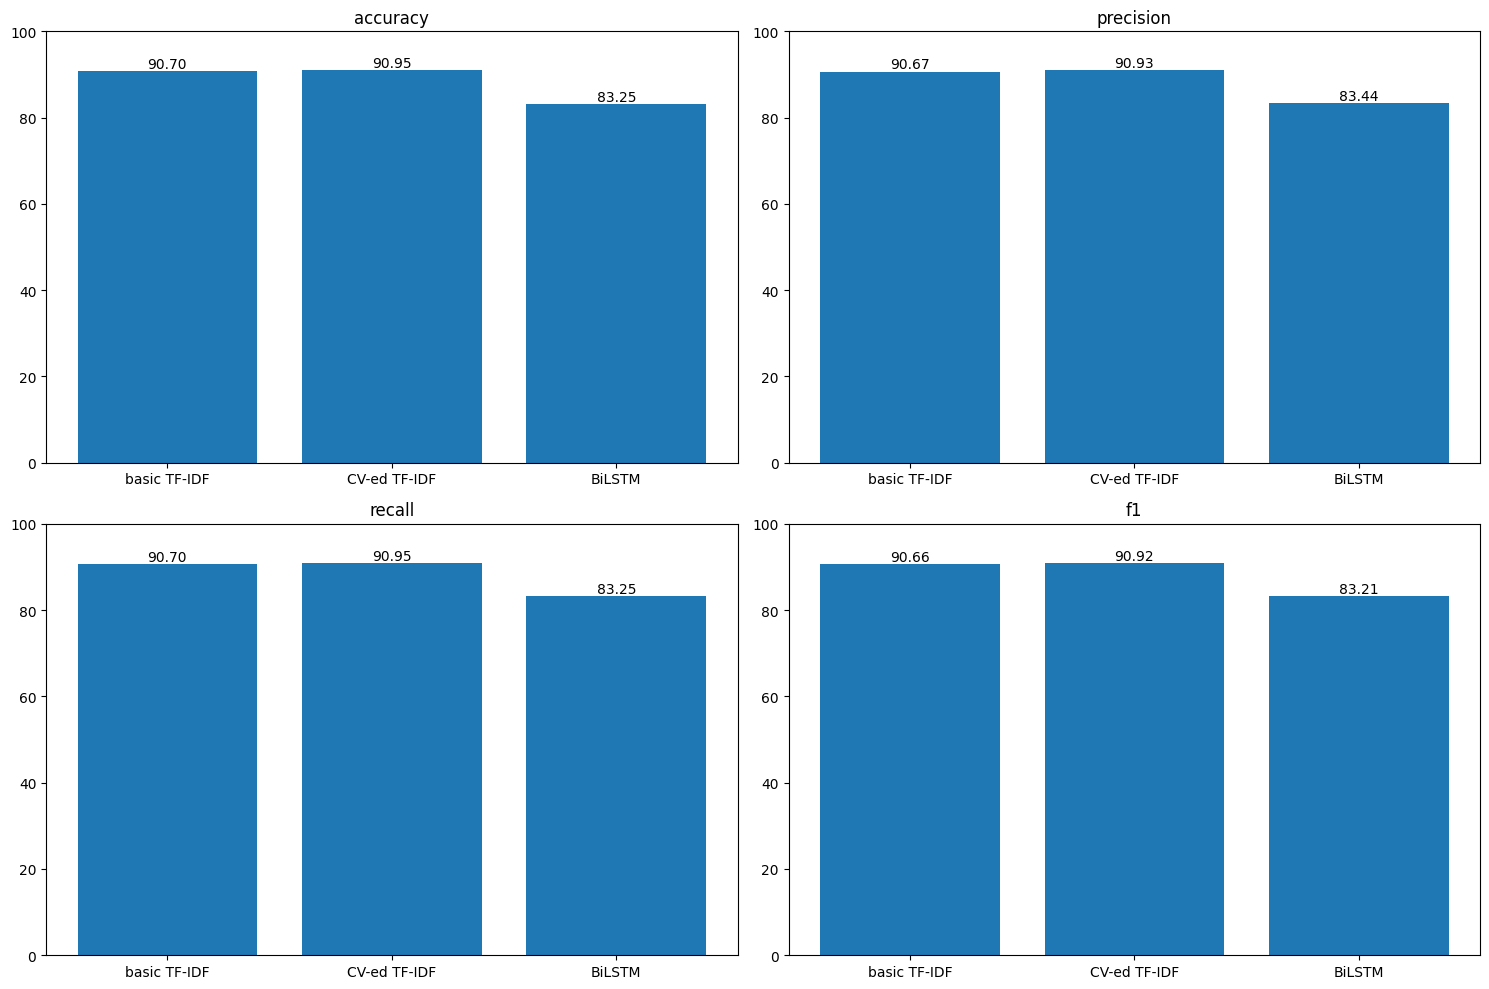

In [14]:
metrics_val.plot()

## Part 3: Word Embedding Add-Ons with Word2Vec

This part focuses on integrating pre-trained word embeddings into our model.

## 1. **Loading Pre-trained Word2Vec Embeddings**:

We'll load Word2Vec embeddings pre-trained on a large corpus.

In [15]:
from staticvectors import StaticVectors

word2vec_model = StaticVectors("neuml/word2vec")


## 2. **Integrating Word2Vec into LSTM Model**:
We'll use these embeddings as inputs to our LSTM model, potentially enhancing its ability to understand context and semantics.

In [18]:
import numpy as np
from tqdm import tqdm

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))  # 300 is the dimensionality of GoogleNews vectors

for word, i in tqdm(tokenizer.word_index.items()):
    if i < vocab_size:
        try:
            embedding_vector = word2vec_model.embeddings([word])
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Word not found in the model, leave as zeros
            continue
# Define the model

model = Sequential([
    Embedding(vocab_size, 300, weights=[embedding_matrix],
              input_length=max_length, trainable=False),  # Set trainable to False
    Bidirectional(LSTM(64)),  # First bidirectional LSTM layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

100%|██████████| 25874/25874 [00:00<00:00, 284470.28it/s]
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

## 3. **Training and Evaluating the Model**:
We'll train our model with these new embeddings and evaluate to see if there's an improvement in performance.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # How many epochs to wait after min has been hit
    verbose=1,  # Verbosity level
    mode='min',  # Mode for the monitored quantity (minimizing loss)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


history = model.fit(
    padded_sequences_train,
    train_labels_lstm,
    epochs=10,
    batch_size=128,
    validation_data=(padded_sequences_valid, valid_labels_lstm),
    callbacks=[early_stopping]
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.5283 - loss: 1.1452 - val_accuracy: 0.8025 - val_loss: 0.5733
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.8341 - loss: 0.4983 - val_accuracy: 0.8445 - val_loss: 0.4534
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8494 - loss: 0.4609 - val_accuracy: 0.8585 - val_loss: 0.4177
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.8683 - loss: 0.4014 - val_accuracy: 0.8550 - val_loss: 0.3938
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.8649 - loss: 0.3874 - val_accuracy: 0.8565 - val_loss: 0.4117
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 0.8768 - loss: 0.3580 - val_accuracy: 0.8600 - val_loss: 0.3720
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8868 - loss: 0.3396 - val_accuracy: 0.8655 - val_loss: 0.3783
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.8851 - loss: 0.3322 - val_accu

## 4. **Model Evaluation**:

Similar to previous parts, we will evaluate our model's performance using appropriate metrics.


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


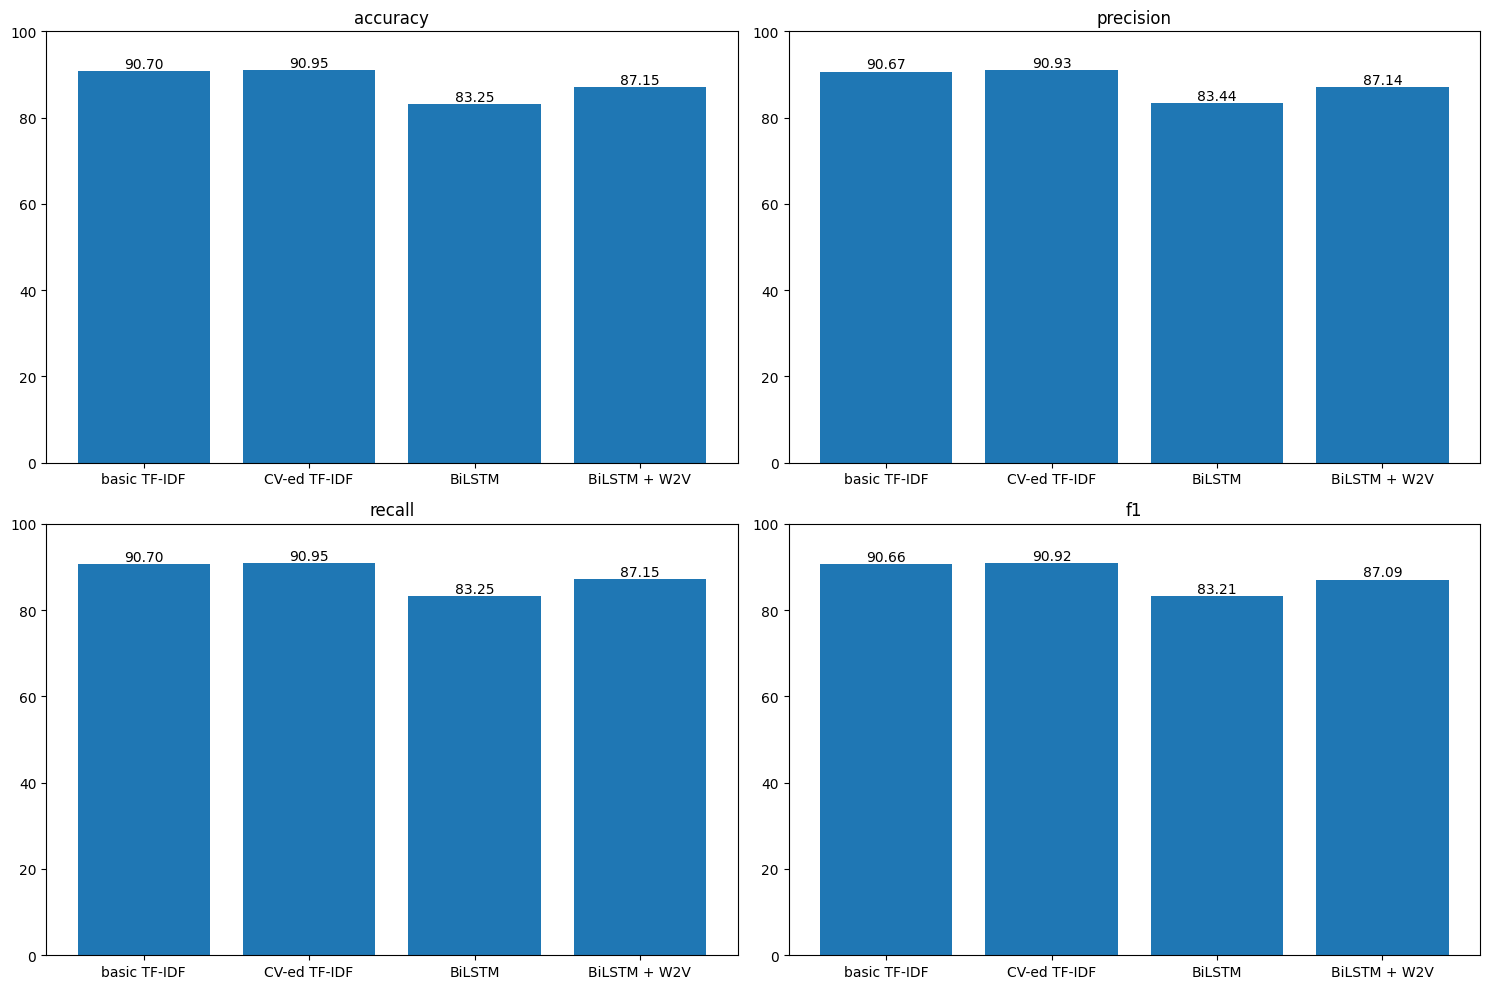

In [20]:
predictions = model.predict(padded_sequences_valid)
valid_preds = np.argmax(predictions, axis=1)
metrics_val.run(valid_labels, valid_preds, "BiLSTM + W2V")
metrics_val.plot()

## Part 4: Model Explainability (LIME / SHAP)

As machine learning models become more powerful, they also become more complex and opaque — especially deep learning models like LSTMs or transformer-based architectures. This complexity makes it harder to understand *why* a model makes a specific prediction.

In this part, we will explore **model explainability**, a crucial step in building trustworthy and transparent machine learning systems.

### 4.1 Why Explainability Matters

Imagine you’ve built a model that predicts whether a customer is likely to churn, or whether a loan should be approved. Even if your model is 90% accurate, you might be asked:

> 🤔 "But why did the model make that decision?"

This is where **explainability** becomes essential.

#### Why it's important:

- **Trust**: Users are more likely to trust predictions they can understand.
- **Debugging**: Helps identify spurious correlations or biases in the model.
- **Fairness & Ethics**: Ensures decisions are not based on sensitive or discriminatory attributes.
- **Regulatory Compliance**: In some domains (like finance or healthcare), explainability is required by law.

#### Two Main Categories of Explainability:

1. **Global Explanations**: Understanding the overall model behavior  
   _Example: Which words generally influence sentiment predictions the most?_

2. **Local Explanations**: Understanding individual predictions  
   _Example: Why was *this* review classified as negative?_

We'll focus primarily on **local explanations** using:
- `LIME` (for simpler models like TF-IDF + Logistic Regression)

Let’s begin by applying LIME to our TF-IDF baseline model.

### 4.2 🧪 Applying LIME to the TF-IDF Model

Now that we understand **why explainability matters**, let's start by applying **LIME** (Local Interpretable Model-agnostic Explanations) to our first model:  
➡️ A **TF-IDF + Logistic Regression** pipeline.

LIME works by slightly perturbing the input text and seeing how the model prediction changes.  
From this, it builds a **local, interpretable surrogate model** (like a linear regression) to approximate the complex model's behavior near that input.

We'll explain:
- A single prediction for a text sample
- Which words had the most impact (positive or negative) on the predicted label


In [41]:
grid_search.best_estimator_.steps[1][1].coef_

array([[-0.07520173, -0.03955091, -0.0271941 , ..., -0.07023967,
        -0.02405555, -0.08414196],
       [-0.02411485,  0.00212361, -0.0315257 , ...,  0.21824993,
         0.08315289,  0.18115417],
       [-0.1058132 , -0.05305574, -0.0448691 , ..., -0.07515513,
        -0.03319374, -0.0554911 ],
       [ 0.19965273,  0.08717298,  0.11158061, ..., -0.07911114,
        -0.04097201, -0.06068008]])

Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted class: Business

Class probabilities:
World: 0.3362
Sports: 0.0388
Business: 0.5302
Sci/Tech: 0.0948


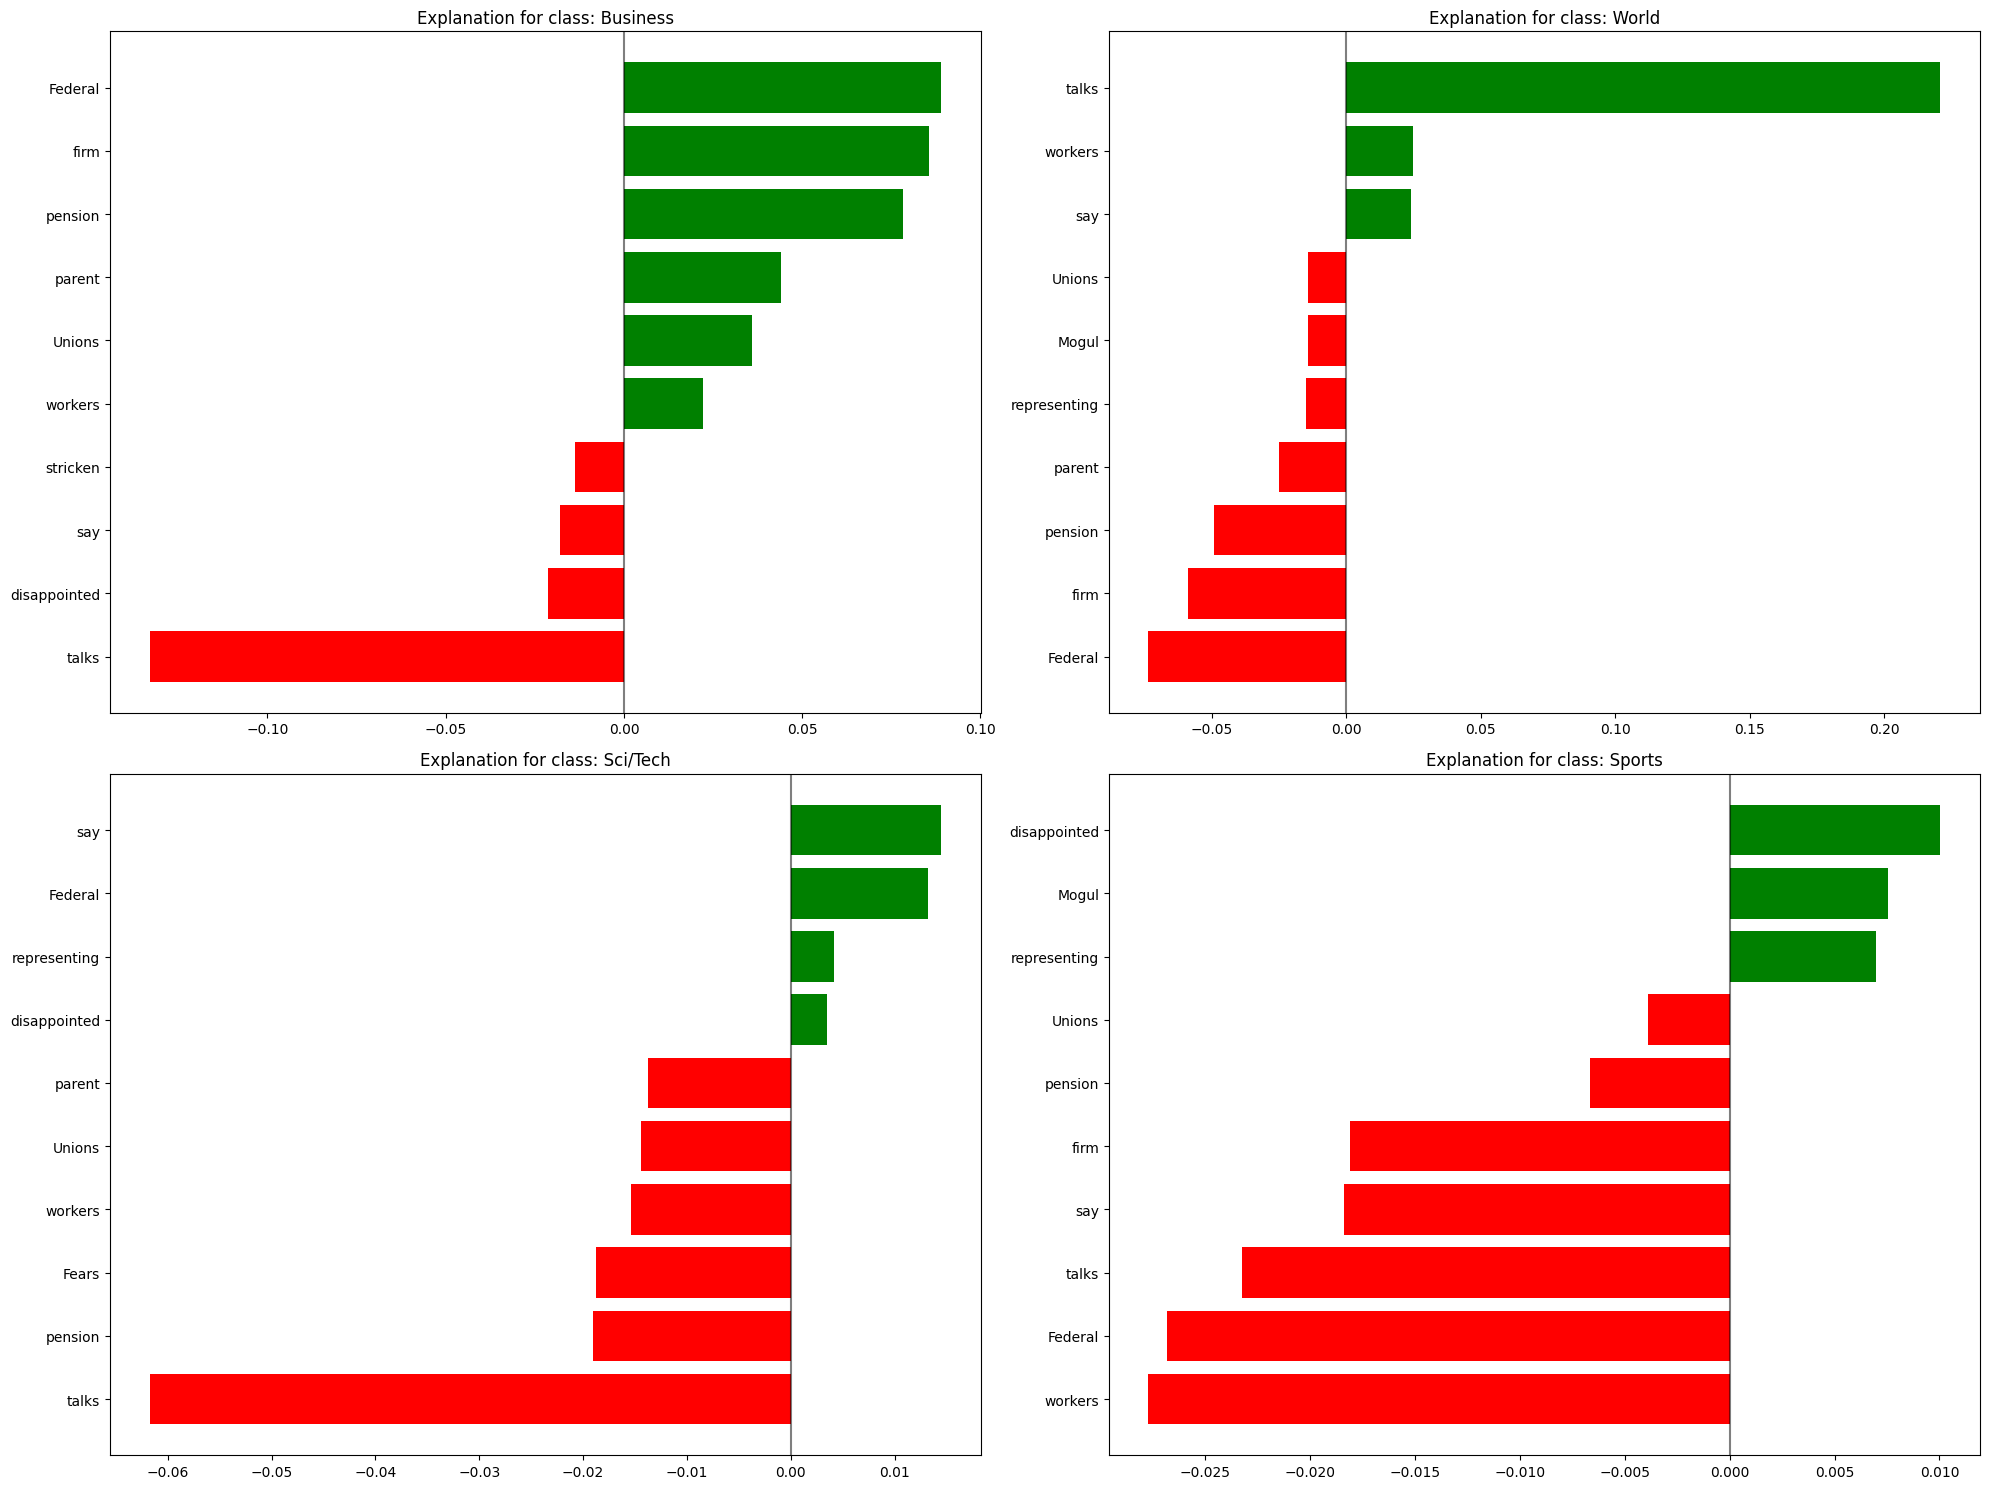


Top features for class: Business
talks: -0.1331
Federal: 0.0891
firm: 0.0856
pension: 0.0784
parent: 0.0440
Unions: 0.0360
workers: 0.0221
disappointed: -0.0212
say: -0.0179
stricken: -0.0136

Top features for class: World
talks: 0.2208
Federal: -0.0736
firm: -0.0590
pension: -0.0491
parent: -0.0250
workers: 0.0248
say: 0.0239
representing: -0.0151
Mogul: -0.0142
Unions: -0.0142

Top features for class: Sci/Tech
talks: -0.0618
pension: -0.0191
Fears: -0.0188
workers: -0.0154
say: 0.0145
Unions: -0.0145
parent: -0.0137
Federal: 0.0132
representing: 0.0042
disappointed: 0.0035

Top features for class: Sports
workers: -0.0277
Federal: -0.0268
talks: -0.0232
say: -0.0184
firm: -0.0181
disappointed: 0.0100
Mogul: 0.0076
representing: 0.0070
pension: -0.0067
Unions: -0.0039


In [47]:
from lime.lime_text import LimeTextExplainer
import shap

# Fixed version of the TF-IDF LIME explainer function
def explain_tfidf_prediction(text_instance, pipeline, class_names):
    # Create a LIME text explainer
    explainer = LimeTextExplainer(class_names=class_names)
    
    # Get explanation for the prediction
    exp = explainer.explain_instance(
        text_instance, 
        pipeline.predict_proba, 
        num_features=10,
        top_labels=len(class_names)  # Explain all classes
    )
    
    # Display basic information
    print(f"Text: {text_instance}")
    pred_class = pipeline.predict([text_instance])[0]
    print(f"Predicted class: {class_names[pred_class]}")
    
    # Get probabilities for all classes
    probs = pipeline.predict_proba([text_instance])[0]
    print("\nClass probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probs[i]:.4f}")
    
    # Create visualization for each class
    plt.figure(figsize=(20, 15))
    
    # Get the labels that LIME actually explained
    top_labels = exp.available_labels()
    
    for i, label_id in enumerate(top_labels):
        plt.subplot(2, 2, i+1)
        
        # Get the explanation for this class
        exp_list = exp.as_list(label=label_id)
        
        # Extract words and weights
        words = [x[0] for x in exp_list]
        weights = [x[1] for x in exp_list]
        
        # Sort for better visualization
        pairs = sorted(zip(words, weights), key=lambda x: x[1])
        words = [x[0] for x in pairs]
        weights = [x[1] for x in pairs]
        
        # Create bar chart
        colors = ['red' if w < 0 else 'green' for w in weights]
        y_pos = np.arange(len(words))
        
        plt.barh(y_pos, weights, color=colors)
        plt.yticks(y_pos, words)
        plt.title(f"Explanation for class: {class_names[label_id]}")
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print top contributing words for each class
    for label_id in top_labels:
        print(f"\nTop features for class: {class_names[label_id]}")
        exp_list = exp.as_list(label=label_id)
        for word, weight in exp_list:
            print(f"{word}: {weight:.4f}")
    
    return exp

# Example text from test set
example_text = test_data[0]
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
lime_exp_tfidf = explain_tfidf_prediction(example_text, grid_search.best_estimator_, class_names)

### 🧠 Interpretation of LIME Explanation

Let's break down what LIME revealed about the model's reasoning for this particular prediction.

#### ✅ Predicted Class: **Business**

LIME shows us the **top 10 words** that contributed **positively** or **negatively** to each possible class (Business, World, Sci/Tech, Sports).

#### 💬 For Class: **Business**
- Words like **"Federal"**, **"firm"**, and **"pension"** have **positive weights**, meaning they support the Business prediction.
- The word **"talks"** actually detracts from the Business prediction (negative weight), suggesting it's a bit ambiguous.

#### 🌍 For Class: **World**
- Interestingly, **"talks"** strongly supports the **World** class here.
- Other Business-related terms (e.g., **"Federal"**, **"firm"**) detract from a World prediction.

#### 💡 Insights:
- Words like **"workers"**, **"Unions"**, and **"say"** appear across multiple classes with small influence, showing they’re more generic.
- **"talks"** is context-dependent – LIME helps us **disentangle how the same word can shift meaning** depending on the rest of the sentence.

🧭 **Takeaway**: LIME helps us peek inside the model's black box and see *which features are driving predictions*. It also shows that certain words may support multiple classes, but with different intensities.

---

Ready to move on? Let’s now explore:

### 4.3 📊 Comparing Explanations for LSTM and Word2Vec Models

➡️ Here, we'll try to interpret more **complex models** (like LSTM and Word2Vec-based models) using LIME and compare how their reasoning differs from the simpler TF-IDF model.

Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted class: Sci/Tech

Class probabilities:
World: 0.0995
Sports: 0.0331
Business: 0.0839
Sci/Tech: 0.7835


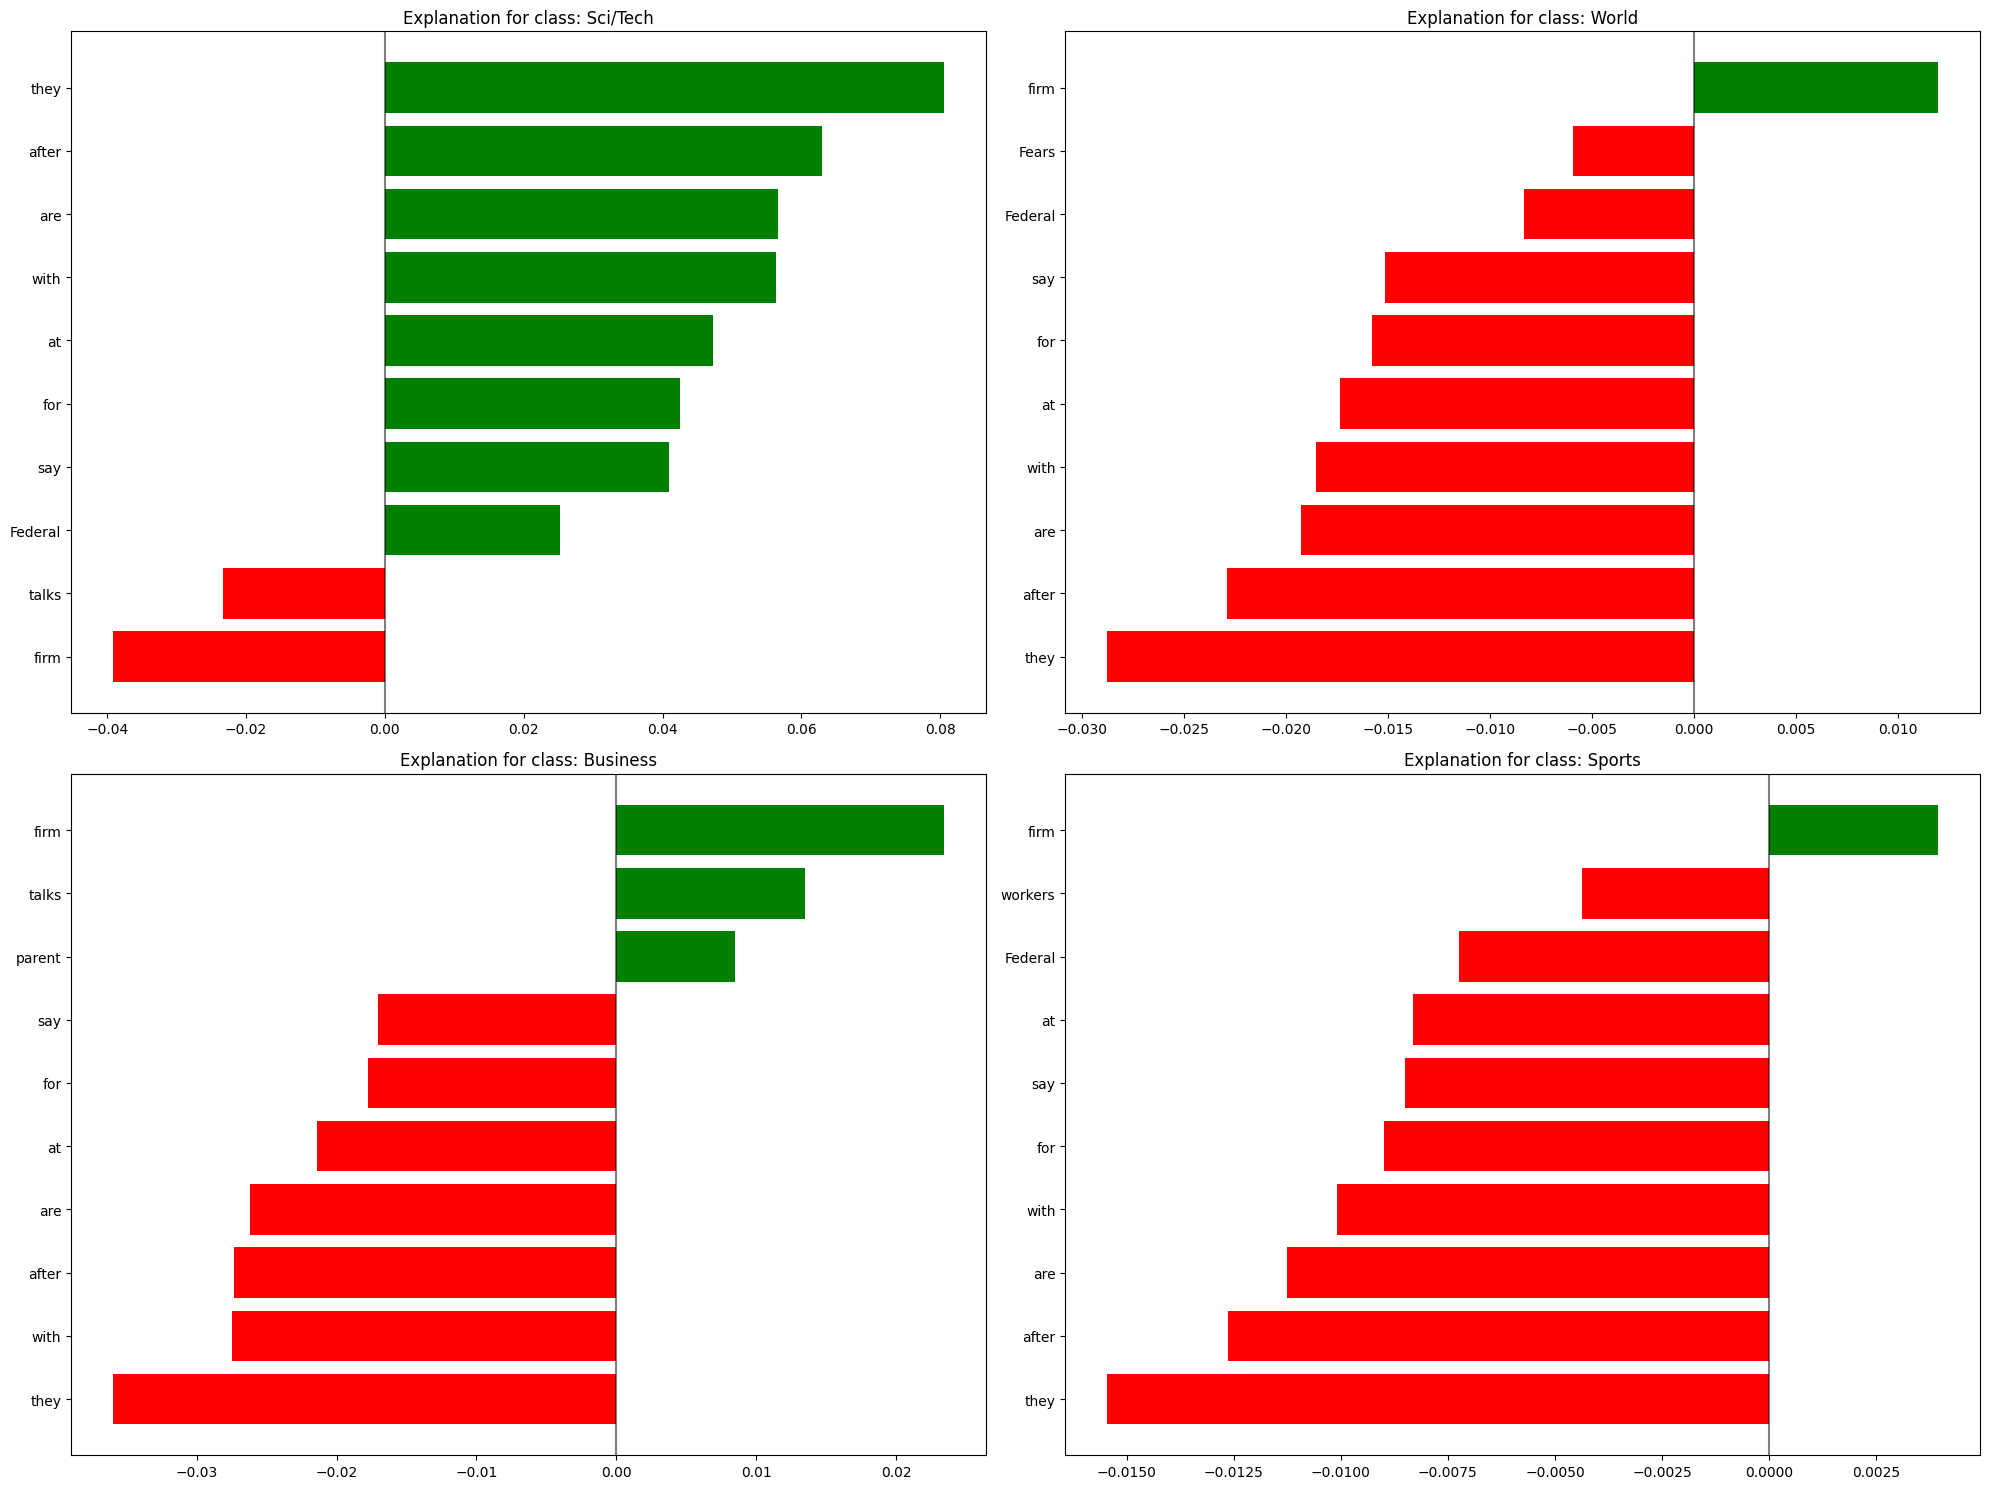


Top features for class: Sci/Tech
they: 0.0806
after: 0.0629
are: 0.0567
with: 0.0564
at: 0.0472
for: 0.0426
say: 0.0409
firm: -0.0392
Federal: 0.0252
talks: -0.0233

Top features for class: World
they: -0.0288
after: -0.0229
are: -0.0193
with: -0.0186
at: -0.0174
for: -0.0158
say: -0.0151
firm: 0.0120
Federal: -0.0084
Fears: -0.0060

Top features for class: Business
they: -0.0360
with: -0.0275
after: -0.0273
are: -0.0262
firm: 0.0235
at: -0.0214
for: -0.0177
say: -0.0170
talks: 0.0135
parent: 0.0085

Top features for class: Sports
they: -0.0155
after: -0.0126
are: -0.0113
with: -0.0101
for: -0.0090
say: -0.0085
at: -0.0083
Federal: -0.0072
workers: -0.0044
firm: 0.0040


In [48]:
def prepare_text_for_lstm(text, tokenizer, max_length):
    """Prepare text input for LSTM model"""
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    sequences = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(sequences, maxlen=max_length)
    return padded_seq

def lstm_predict_proba(texts):
    """Prediction function for LIME to use with LSTM model"""
    result = np.zeros((len(texts), len(class_names)))
    for i, text in enumerate(texts):
        padded = prepare_text_for_lstm(text, tokenizer, max_length)
        pred = model.predict(padded, verbose=0)
        result[i] = pred[0]
    return result

def explain_lstm_prediction(text_instance, class_names):
    # Create a LIME text explainer
    explainer = LimeTextExplainer(class_names=class_names)
    
    # Get explanation for the prediction
    exp = explainer.explain_instance(
        text_instance, 
        lstm_predict_proba, 
        num_features=10,
        top_labels=len(class_names)  # Explain all classes
    )
    
    # Display basic information
    print(f"Text: {text_instance}")
    padded = prepare_text_for_lstm(text_instance, tokenizer, max_length)
    prediction = model.predict(padded, verbose=0)
    predicted_class = np.argmax(prediction[0])
    print(f"Predicted class: {class_names[predicted_class]}")
    
    # Get probabilities for all classes
    probs = prediction[0]
    print("\nClass probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probs[i]:.4f}")
    
    # Create visualization for each class
    plt.figure(figsize=(20, 15))
    
    # Get the labels that LIME actually explained
    top_labels = exp.available_labels()
    
    for i, label_id in enumerate(top_labels):
        plt.subplot(2, 2, i+1)
        
        # Get the explanation for this class
        exp_list = exp.as_list(label=label_id)
        
        # Extract words and weights
        words = [x[0] for x in exp_list]
        weights = [x[1] for x in exp_list]
        
        # Sort for better visualization
        pairs = sorted(zip(words, weights), key=lambda x: x[1])
        words = [x[0] for x in pairs]
        weights = [x[1] for x in pairs]
        
        # Create bar chart
        colors = ['red' if w < 0 else 'green' for w in weights]
        y_pos = np.arange(len(words))
        
        plt.barh(y_pos, weights, color=colors)
        plt.yticks(y_pos, words)
        plt.title(f"Explanation for class: {class_names[label_id]}")
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print top contributing words for each class
    for label_id in top_labels:
        print(f"\nTop features for class: {class_names[label_id]}")
        exp_list = exp.as_list(label=label_id)
        for word, weight in exp_list:
            print(f"{word}: {weight:.4f}")
    
    return exp

example_text = test_data[0]
model_exp_lime = explain_lstm_prediction(example_text, class_names)

### 🔍 LIME Explanation for LSTM Model

#### 🧠 Sentence Analyzed:
> "Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."

#### ✅ Predicted Class: **Sci/Tech**  
With a **very high probability (78.35%)**, the LSTM model predicted this text belongs to **Sci/Tech**.

#### 📊 Class Probabilities:
- Sci/Tech: **0.7835**
- World: 0.0995
- Business: 0.0839
- Sports: 0.0331

---

### 💡 What LIME Reveals

#### Top Features Supporting **Sci/Tech**:
- Common connectors like **"they"**, **"after"**, **"are"**, **"with"**, and **"at"** surprisingly contribute **positively** to Sci/Tech.
- Words like **"firm"** and **"talks"**, which might intuitively relate to Business or World, actually **reduce** the Sci/Tech probability here.

#### Across Other Classes:
- Most of the same function words (**"they"**, **"after"**, **"with"**) appear as **negative** contributors to **World**, **Business**, and **Sports** classes.
- Words like **"firm"** slightly **boost** the Business class but are downplayed for Sci/Tech.
- In the **Sports** class, all top words negatively influence the prediction, confirming it’s a poor match.

---

### 🧠 Interpretation:
Unlike the TF-IDF model, which focused on *specific content words*, the LSTM model seems to be relying heavily on **syntactic or structural features** (like function words and word order). This could be due to:
- The sequential nature of LSTM, which captures **contextual dependencies**
- A possible **lack of domain-specific keywords** driving this prediction